# Analysis of Detached Housing Sales in Western Prince William County, Virginia from 1/1/2000 - 6/15/2021


## Import Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('notebook')
sns.set_style('white')
import scipy.stats as stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import TransformedTargetRegressor, make_column_transformer, make_column_selector
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline

import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import RepeatedKFold, cross_val_score

## Import Data

The base dataframe has 52,757 sales observations from 1/1/2000 to 7/13/2021.

The historic housing sales data covers housing sales from the following zip codes: 20108, 20109, 20110, 20111, 20112, 20136, 20155, 20156, 20168, 20169, and 20181.

Multiple columns contain missing (null) data points.  The first part of the analysis will involve cleaning the dataframe, handling null values, correcting obvious data anomalies and performing analysis pertaining to that particular column.

In [2]:
df = pd.read_csv('data/detached_sales.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52758 entries, 0 to 52757
Data columns (total 27 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   MLS #                      52758 non-null  object 
 1   Address                    52758 non-null  object 
 2   Zip Code                   52758 non-null  int64  
 3   City                       52758 non-null  object 
 4   DOM                        52758 non-null  object 
 5   Close Date                 52758 non-null  object 
 6   Close Price                52758 non-null  object 
 7   Beds                       52758 non-null  int64  
 8   Bathrooms Full             52758 non-null  int64  
 9   Bathrooms Half             47623 non-null  float64
 10  Subdivision/Neighborhood   52757 non-null  object 
 11  Structure Type             52758 non-null  object 
 12  Basement                   52758 non-null  object 
 13  Fireplaces Total           51530 non-null  flo

In [4]:
df.isnull().sum()

MLS #                            0
Address                          0
Zip Code                         0
City                             0
DOM                              0
Close Date                       0
Close Price                      0
Beds                             0
Bathrooms Full                   0
Bathrooms Half                5135
Subdivision/Neighborhood         1
Structure Type                   0
Basement                         0
Fireplaces Total              1228
Levels/Stories                  65
Total Garage Spaces          12445
Above Grade Finished SQFT    22529
Below Grade Finished SQFT    30870
Condo/Coop Assoc YN              3
Fireplace                     1776
Garage                           0
HOA YN                           0
List Price                       0
Lot Size SqFt                   84
School District              31924
Total Finished SQFT          22464
Year Built                      14
dtype: int64

The following dataset import is a dataset that contains the transaction history for a specific agent for inclusion in analysis later on in the project

In [5]:
agent_transactions_df = pd.read_csv('data/agent_transactions.csv')

In [6]:
agent_transactions_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   mls_num                     74 non-null     object 
 1   use                         74 non-null     int64  
 2   type                        74 non-null     object 
 3   type_description            74 non-null     object 
 4   street_address              74 non-null     object 
 5   city                        74 non-null     object 
 6   list_price                  74 non-null     int64  
 7   sold_price                  74 non-null     int64  
 8   list_date                   74 non-null     object 
 9   sold_date                   74 non-null     object 
 10  days_on_market              74 non-null     int64  
 11  list_to_close_days          74 non-null     int64  
 12  ratification_to_close_days  74 non-null     int64  
 13  list_year                   74 non-nu

## Data Cleaning

Data cleaning will first concentrate on cleaning the agent_transaction_df dataframe before moving onto the primary dataframe, df, which contains the 20+ years of house sales.

In [7]:
agent_transactions_df.head()

,mls_num,use,type,type_description,street_address,city,list_price,sold_price,list_date,sold_date,days_on_market,list_to_close_days,ratification_to_close_days,list_year,sold_year,Unnamed: 15,Unnamed: 16
0,1000295275,1,listed_coop_sold,sell,8935 Sweetbriar,Manassas,337500,337500,3/25/16,4/29/16,5,36,31,2016,2016,NaN,1000295275
1,1000321115,0,coop_listed_sold,buy,4205 Roeburn,Woodbridge,974990,936500,7/6/16,12/30/16,117,178,61,2016,2016,NaN,NaN
2,1000341439,0,coop_listed_sold,buy,6914 Bitterroot,Gainesville,465000,475000,9/21/16,10/28/16,4,38,34,2016,2016,NaN,1000341439
3,1000355417,0,coop_listed_sold,buy,8214 Winstead #102,Manassas,199000,190000,11/16/16,12/28/16,12,43,31,2016,2016,NaN,NaN
4,1001324077,0,coop_listed_sold,buy,755 Aylor,Stephens City,220000,213000,6/8/15,5/4/16,250,332,82,2015,2016,NaN,NaN


In [8]:
agent_buy_sell_dual_df = agent_transactions_df.loc[
                         (agent_transactions_df.type_description == 'sell')|
                         (agent_transactions_df.type_description == 'buy')|
                         (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [9]:
agent_buy_sell_dual_df

,index,mls_num,use,type,type_description,street_address,city,list_price,sold_price,list_date,sold_date,days_on_market,list_to_close_days,ratification_to_close_days,list_year,sold_year,Unnamed: 15,Unnamed: 16
0,0,1000295275,1,listed_coop_sold,sell,8935 Sweetbriar,Manassas,337500,337500,3/25/16,4/29/16,5,36,31,2016,2016,NaN,1000295275
1,1,1000321115,0,coop_listed_sold,buy,4205 Roeburn,Woodbridge,974990,936500,7/6/16,12/30/16,117,178,61,2016,2016,NaN,NaN
2,2,1000341439,0,coop_listed_sold,buy,6914 Bitterroot,Gainesville,465000,475000,9/21/16,10/28/16,4,38,34,2016,2016,NaN,1000341439
3,3,1000355417,0,coop_listed_sold,buy,8214 Winstead #102,Manassas,199000,190000,11/16/16,12/28/16,12,43,31,2016,2016,NaN,NaN
4,4,1001324077,0,coop_listed_sold,buy,755 Aylor,Stephens City,220000,213000,6/8/15,5/4/16,250,332,82,2015,2016,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
61,69,VAMN141456,1,listed_coop_sold,sell,8886 Quarry Rd,Manassas,424999,438000,3/26/21,5/17/21,6,53,47,2021,2021,NaN,NaN
62,70,VAMN141736,1,listed_coop_sold,sell,8924 Longstreet Dr,Manassas,599999,629000,4/29/21,6/1/21,0,34,34,2021,2021,NaN,VAMN141736
63,71,VAPW516932,0,coop_listed_sold,buy,11951 Bluegrass Ct,Nokesville,699999,725000,3/24/21,4/30/21,4,38,34,2021,2021,NaN,VAPW516932
64,72,VAMN142132,1,listed_coop_sold,sell,8683 Point of Woods,Manassas,359000,373000,6/10/21,7/9/21,5,30,25,2021,2021,NaN,NaN


In [10]:
agent_buy_sell_dual_mls_num = list(agent_buy_sell_dual_df.mls_num)

In [11]:
agent_buy_sell_dual_mls_num

['1000295275',
 '1000321115',
 '1000341439',
 '1000355417',
 '1001324077',
 '1002604652',
 '1002614678',
 '1000172637',
 '1000368267',
 '1000368739',
 '1000381843',
 '1000385543',
 '1000389835',
 '1000390055',
 '1000390671',
 '1000983977',
 '1001639763',
 '1001640931',
 '1001788297',
 '1004121557',
 '1000379225',
 '1002121356',
 'VAPW100302',
 '1000361786',
 '1000426604',
 '1000426798',
 '1000450686',
 '1001184340',
 '1001950134',
 '1002346450',
 '1003289680',
 'VAMN100010',
 '1000363376',
 '1002013606',
 '1002149434',
 '1004472545',
 '1005468057',
 '1005958667',
 '1007546104',
 '1002345500',
 'VAMN100013',
 'VAMN138342',
 'VAPW432086',
 'VAPW474548',
 'VAPW475184',
 'VAPW480200',
 'VAMN138052',
 'VAFQ165798',
 'VAMP114154',
 'VAPW472988',
 'VAPW487094',
 'VAPW487732',
 'VAPW498766',
 'VAFX1149450',
 'VAMN139398',
 'VAPW496830',
 'VAPW520948',
 'VALO428754',
 'VAPW515698',
 'VAPW517998',
 'VAMN141710',
 'VAMN141456',
 'VAMN141736',
 'VAPW516932',
 'VAMN142132',
 'VAFX2004794']

For analysis, create datframes that capture all of the agent's sales and all of the agent's buys.  Listings where the agent was an alternate agent will not be used. Listings where the agent was acting as a dual agent will be used.

In [12]:
agent_sales_df = agent_transactions_df.loc[
                 (agent_transactions_df.type_description == 'sell') |
                 (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [13]:
agent_sales_df

,index,mls_num,use,type,type_description,street_address,city,list_price,sold_price,list_date,sold_date,days_on_market,list_to_close_days,ratification_to_close_days,list_year,sold_year,Unnamed: 15,Unnamed: 16
0,0,1000295275,1,listed_coop_sold,sell,8935 Sweetbriar,Manassas,337500,337500,3/25/16,4/29/16,5,36,31,2016,2016,NaN,1000295275
1,15,1000172637,1,listed_coop_sold,sell,8420 Tackhouse,Gainesville,349000,349000,7/26/17,9/29/17,7,66,59,2017,2017,NaN,NaN
2,16,1000368267,1,listed_coop_sold,sell,7595 Gales #4B-101,Manassas,119900,110000,2/8/17,3/23/17,19,44,25,2017,2017,NaN,NaN
3,17,1000368739,1,listed_coop_sold,sell,9283 Sumner Lake,Manassas,549900,553000,2/15/17,5/12/17,12,87,75,2017,2017,NaN,1000368739
4,18,1000381843,1,listed_coop_sold,sell,9000 Sandalwood #D,Manassas,195000,182000,4/5/17,8/18/17,96,136,40,2017,2017,NaN,NaN
5,19,1000385543,1,listed_coop_sold,sell,11008 Sentry Ridge #5,Manassas,199999,195000,4/27/17,8/14/17,68,110,42,2017,2017,NaN,NaN
6,20,1000389835,1,listed_coop_sold,sell,13307 Maple Leaf,Woodbridge,299999,300000,7/12/17,8/18/17,4,38,34,2017,2017,NaN,NaN
7,21,1000390055,1,listed_coop_sold,sell,8635 Swann,Manassas Park,249900,245000,7/15/17,8/22/17,5,39,34,2017,2017,NaN,NaN
8,22,1000390671,1,listed_coop_sold,sell,9789 Mock Orange,Manassas,249999,232000,7/11/17,8/15/17,5,36,31,2017,2017,NaN,NaN
9,23,1000983977,1,listed_coop_sold,sell,6773 River,Manassas,449000,440000,9/13/17,11/22/17,46,71,25,2017,2017,NaN,1000983977


In [14]:
agent_sales_mls_num = list(agent_sales_df.mls_num)

In [15]:
agent_buys_df = agent_transactions_df.loc[
    (agent_transactions_df.type_description == 'buy') |
    (agent_transactions_df.type_description == 'dual'), :].reset_index()

In [16]:
agent_buys_df

,index,mls_num,use,type,type_description,street_address,city,list_price,sold_price,list_date,sold_date,days_on_market,list_to_close_days,ratification_to_close_days,list_year,sold_year,Unnamed: 15,Unnamed: 16
0,1,1000321115,0,coop_listed_sold,buy,4205 Roeburn,Woodbridge,974990,936500,7/6/16,12/30/16,117,178,61,2016,2016,NaN,NaN
1,2,1000341439,0,coop_listed_sold,buy,6914 Bitterroot,Gainesville,465000,475000,9/21/16,10/28/16,4,38,34,2016,2016,NaN,1000341439
2,3,1000355417,0,coop_listed_sold,buy,8214 Winstead #102,Manassas,199000,190000,11/16/16,12/28/16,12,43,31,2016,2016,NaN,NaN
3,4,1001324077,0,coop_listed_sold,buy,755 Aylor,Stephens City,220000,213000,6/8/15,5/4/16,250,332,82,2015,2016,NaN,NaN
4,5,1002604652,0,coop_listed_sold,buy,River Mill Rd,Richardsville,58999,55000,5/7/15,4/20/16,313,350,37,2015,2016,NaN,NaN
5,6,1002614678,0,coop_listed_sold,buy,0 River Mill Road,Richardsville,58999,55000,5/18/15,4/20/16,302,339,37,2015,2016,NaN,NaN
6,28,1000379225,0,coop_listed_sold,buy,8853 Old Lewis,Manassas,445000,445000,4/1/17,6/23/17,27,84,57,2017,2017,NaN,1000379225
7,29,1002121356,1,listed_sold,dual,9026 Coriander,Manassas,299000,305000,6/14/18,7/13/18,0,30,30,2018,2018,NaN,NaN
8,30,VAPW100302,1,listed_sold,dual,10629 Provincial #C,Manassas,162000,154000,11/1/18,11/1/18,0,1,1,2018,2018,NaN,NaN
9,40,1000363376,0,coop_listed_sold,buy,6449 Waterdale,Bealeton,348888,345000,4/6/18,6/26/18,19,82,63,2018,2018,NaN,NaN


In [17]:
agent_buys_mls_num = list(agent_buys_df.mls_num)

### Column Headers

In [18]:
df.columns = df.columns.str.replace(' ', '_')
df.columns = df.columns.str.replace('/', '_')
df.columns = df.columns.str.lower()

### Add columns to capture agent_transaction_df derivative dataframe information

Add column to flag an observation as whether it belongs to the agent as a sale or dual agency.

In [19]:
df.loc[df['mls_#'].isin(agent_sales_mls_num), :]

,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,below_grade_finished_sqft,condo_coop_assoc_yn,fireplace,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built
38923,1000295275,8935 Sweetbriar St,20110,Manassas,5,4/29/16,"$337,500.00",3,2,1.0,...,NaN,No,No,Yes,No,"$337,500.00",10956.0,Manassas City Public Schools,"1,500",1978.0
41538,1000368739,9283 Sumner Lake Blvd,20110,Manassas,12,5/12/17,"$553,000.00",4,3,1.0,...,"1,684",No,Yes,Yes,Yes,"$549,900.00",18422.0,Manassas City Public Schools,"5,241",2003.0
43097,1000983977,6773 River Rd,20111,Manassas,46,11/22/17,"$440,000.00",3,3,0.0,...,"1,100",No,Yes,Yes,No,"$449,000.00",43560.0,Prince William County Public Schools,"2,501",1984.0
44222,1000361786,1610 Mountain Rd,20169,Haymarket,11,5/30/18,"$375,000.00",4,2,1.0,...,988,No,Yes,Yes,No,"$374,999.00",46888.0,Prince William County Public Schools,"2,600",1980.0
44504,1000426604,6914 Bitterroot Ct,20155,Gainesville,29,6/27/18,"$495,000.00",4,2,1.0,...,850,No,Yes,Yes,Yes,"$489,999.00",6294.0,Prince William County Public Schools,"3,634",2005.0
44639,1001950134,8309 Tillett Loop,20110,Manassas,17,7/12/18,"$441,000.00",4,2,1.0,...,NaN,No,Yes,Yes,Yes,"$441,000.00",5821.0,Manassas City Public Schools,"2,690",2003.0
45587,1002346450,11913 Smithfield Rd,20112,Manassas,53,11/30/18,"$340,000.00",3,3,0.0,...,480,No,Yes,Yes,No,"$364,999.00",35000.0,Prince William County Public Schools,"1,779",1972.0
46649,VAPW432086,7787 Fern Oak Ct,20112,Manassas,54,5/30/19,"$415,000.00",3,3,1.0,...,954,No,Yes,Yes,No,"$414,900.00",53222.0,Prince William County Public Schools,"2,794",1981.0
47495,VAPW474548,10459 Labrador Loop,20112,Manassas,2,8/29/19,"$445,000.00",5,2,1.0,...,0,No,Yes,Yes,Yes,"$439,999.00",8268.0,Prince William County Public Schools,"2,740",1989.0
47870,VAPW480200,4107 Mount Atlas Ln,20169,Haymarket,4,10/21/19,"$400,000.00",3,2,1.0,...,522,No,No,Yes,No,"$395,000.00",45969.0,Prince William County Public Schools,"1,668",1996.0


In [20]:
df['mls_#'].isin(agent_sales_mls_num)

0        False
1        False
2        False
3        False
4        False
         ...  
52753    False
52754    False
52755    False
52756    False
52757    False
Name: mls_#, Length: 52758, dtype: bool

In [21]:
df['agent_sale_dual'] = df['mls_#'].isin(agent_sales_mls_num)

In [22]:
df.head()

,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,condo_coop_assoc_yn,fireplace,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built,agent_sale_dual
0,VAPW289124,10087 Post Oak Terrace,20110,Manassas,12,1/3/00,"$304,417.00",4,2,1.0,...,No,Yes,Yes,No,"$271,000.00",16453.0,Prince William County Public Schools,"3,134",1999.0,False
1,VAPW250326,7409 Howell Run Ct,20112,Manassas,1,1/4/00,"$311,528.00",4,3,1.0,...,No,Yes,Yes,No,"$311,528.00",20364.0,NaN,NaN,1999.0,False
2,VAPW284200,8543 Dover Downs Ct,20155,Gainesville,5,1/6/00,"$219,500.00",3,2,1.0,...,No,Yes,Yes,No,"$219,500.00",13425.0,Prince William County Public Schools,"2,130",1997.0,False
3,VAPW289210,10415 Labrador Loop,20112,Manassas,3,1/6/00,"$199,950.00",4,2,1.0,...,No,Yes,Yes,No,"$199,950.00",7980.0,NaN,NaN,1991.0,False
4,VAPW292248,7544 Belle Grae Dr #1-5,20109,Manassas,456,1/6/00,"$56,000.00",3,2,NaN,...,No,No,No,No,"$56,000.00",0.0,NaN,NaN,1986.0,False


In [23]:
agent_sale_dual_map = {'Yes': 1,
                       'No': 0}

df['agent_sale_dual'] = df.agent_sale_dual.replace(agent_sale_dual_map).astype('int')

In [24]:
df.head()

,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,condo_coop_assoc_yn,fireplace,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built,agent_sale_dual
0,VAPW289124,10087 Post Oak Terrace,20110,Manassas,12,1/3/00,"$304,417.00",4,2,1.0,...,No,Yes,Yes,No,"$271,000.00",16453.0,Prince William County Public Schools,"3,134",1999.0,0
1,VAPW250326,7409 Howell Run Ct,20112,Manassas,1,1/4/00,"$311,528.00",4,3,1.0,...,No,Yes,Yes,No,"$311,528.00",20364.0,NaN,NaN,1999.0,0
2,VAPW284200,8543 Dover Downs Ct,20155,Gainesville,5,1/6/00,"$219,500.00",3,2,1.0,...,No,Yes,Yes,No,"$219,500.00",13425.0,Prince William County Public Schools,"2,130",1997.0,0
3,VAPW289210,10415 Labrador Loop,20112,Manassas,3,1/6/00,"$199,950.00",4,2,1.0,...,No,Yes,Yes,No,"$199,950.00",7980.0,NaN,NaN,1991.0,0
4,VAPW292248,7544 Belle Grae Dr #1-5,20109,Manassas,456,1/6/00,"$56,000.00",3,2,NaN,...,No,No,No,No,"$56,000.00",0.0,NaN,NaN,1986.0,0


### close_price

In [25]:
df['close_price'] = df.close_price.str.replace('$', '', regex=False)
df['close_price'] = df.close_price.str.replace(',', '')
df['close_price'] = df.close_price.str.split('.', 1, expand=True)[0].astype(int)

Check for odd closing prices at the low end

In [26]:
df.loc[df.close_price <= 10_000, :]

,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,condo_coop_assoc_yn,fireplace,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built,agent_sale_dual
41,VAPW273384,14456 Sedona Dr,20155,Gainesville,137,1/25/00,2200,5,3,1.0,...,No,Yes,Yes,No,"$374,500.00",12384.0,NaN,"4,436",1997.0,0
45684,1002244130,13550 Frost Dr,20181,Nokesville,46,12/17/18,4310,5,3,1.0,...,No,Yes,No,No,"$432,900.00",69731.0,Prince William County Public Schools,"2,876",1985.0,0


MLS # VAPW273384 looks as if the agent did not input the correct closing price, so the close_price will be changed to $322,000 from 2200.

MLS # 1002244130 looks as if the agent did not add the trailing two 0s to the sale documentation, so the close_price will be changed to $431,000


In [27]:
df['close_price'] = np.where(df.close_price == 2200, 322000, df.close_price)
df['close_price'] = np.where(df.close_price == 4310, 431000, df.close_price)


Check for odd closing prices at the high end

In [28]:
df.loc[df.close_price >= 1_500_000, :]

,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,condo_coop_assoc_yn,fireplace,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built,agent_sale_dual
8372,VAPW202628,6110 James Madison Hwy,20169,Haymarket,114,11/7/03,1950000,3,2,NaN,...,No,Yes,Yes,No,"$1,950,000.00",1004406.0,NaN,"3,280",1964.0,0
9943,VAPW148752,11200 Crockett Rd,20181,Nokesville,1,5/27/04,3000000,4,3,0.0,...,No,No,Yes,No,"$3,000,000.00",8463634.0,Prince William County Public Schools,"3,552",1978.0,0
10254,VAPW151028,13207 Old Church Rd,20181,Nokesville,1,6/25/04,1800000,4,3,1.0,...,No,Yes,Yes,No,"$1,800,000.00",2632387.0,NaN,"3,960",1901.0,0
12284,VAPW167326,11714 Bristow Rd,20136,Bristow,0,1/5/05,2500000,4,2,0.0,...,No,No,No,No,"$2,500,000.00",7261452.0,NaN,"2,326",1954.0,0
14425,VAPW175576,15858 Spyglass Hill Loop,20155,Gainesville,31,8/1/05,1699990,5,4,2.0,...,No,Yes,Yes,Yes,"$1,700,000.00",31799.0,Prince William County Public Schools,"4,850",2005.0,0
15361,VAPW187910,15151 Riding Club Dr,20169,Haymarket,13,11/9/05,2263060,4,5,2.0,...,No,Yes,Yes,Yes,"$2,300,000.00",435600.0,NaN,NaN,2005.0,0
15403,VAPW165752,14316 Bristow Rd,20112,Manassas,209,11/15/05,1900000,8,6,3.0,...,No,Yes,Yes,No,"$1,999,950.00",588922.0,Prince William County Public Schools,NaN,1992.0,0
16401,VAPW180982,16915 Thunder Rd,20169,Haymarket,122,3/31/06,1950000,4,7,0.0,...,No,Yes,Yes,Yes,"$2,350,000.00",872507.0,NaN,"9,000",1998.0,0
17089,VAPW183502,8514 Link Hills Loop,20155,Gainesville,320,7/11/06,1598323,4,3,1.0,...,No,Yes,Yes,Yes,"$1,598,323.20",19602.0,Prince William County Public Schools,"4,534",2005.0,0
17223,VAPW178422,15830 Spyglass Hill Loop,20155,Gainesville,408,7/31/06,2159765,5,7,2.0,...,No,Yes,Yes,Yes,"$2,159,765.00",32670.0,NaN,NaN,2006.0,0


Plot of close_price distribution

Text(0, 0.5, 'Closing Price Frequency')

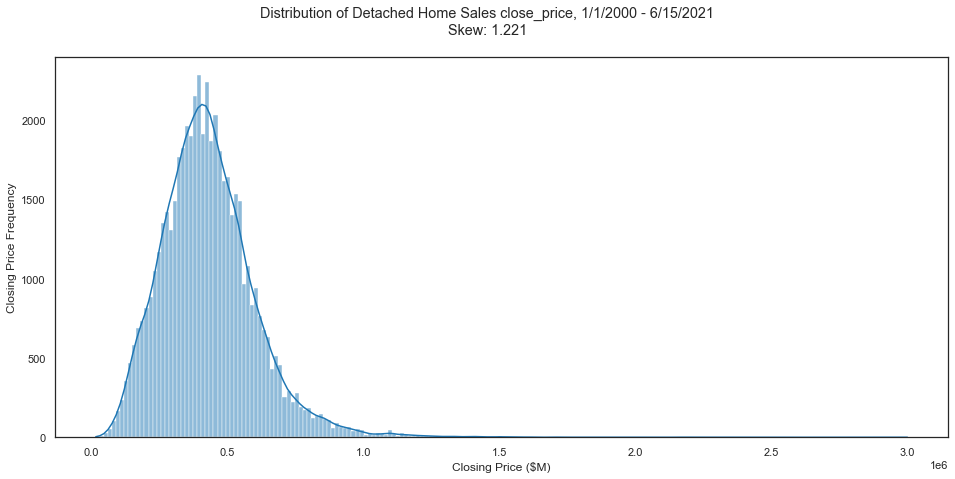

In [29]:
fig1, ax0 = plt.subplots(1, 1, figsize=(16, 7))
fig1.suptitle(f'Distribution of Detached Home Sales close_price, 1/1/2000 - 6/15/2021\n'
              f'Skew: {round(df.close_price.skew(), 3)}')

sns.histplot(data=df,
             x=df.close_price,
             bins= 200,
             kde=True,
             ax = ax0)

ax0.set_xlabel('Closing Price ($M)')
ax0.set_ylabel('Closing Price Frequency')

Plot comparing original close_price and log-transformed close_price distributions.

The log transformation creates a nearly-normal distribution of the closing prices. The skew measurement improved from 1.221 to -0.649. When performing modeling procedures, the closing price variable will need to be log-transformed.

Text(0, 0.5, 'Closing Price Frequency')

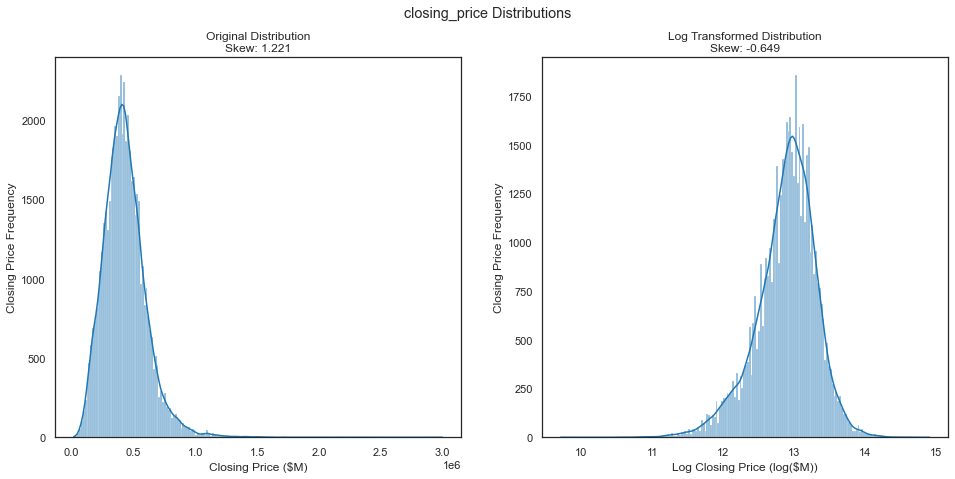

In [30]:
fig2, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7))
fig2.suptitle('closing_price Distributions')

sns.histplot(data=df,
             x=df.close_price,
             bins= 200,
             kde=True,
             ax = ax0)
ax0.set_title(f'Original Distribution\n'
              f'Skew: {round(df.close_price.skew(), 3)}')
ax0.set_xlabel('Closing Price ($M)')
ax0.set_ylabel('Closing Price Frequency')

sns.histplot(data=df,
             x=np.log(df['close_price']),
             bins= 200,
             kde=True,
             ax = ax1)
ax1.set_title(f'Log Transformed Distribution\n'
              f'Skew: {round(np.log(df.close_price).skew(), 3)}')
ax1.set_xlabel('Log Closing Price (log($M))')
ax1.set_ylabel('Closing Price Frequency')

### close_date

In [31]:
df['close_date'] = pd.to_datetime(df.close_date)
df['close_month'] = pd.DatetimeIndex(df.close_date).month
df['close_year'] = pd.DatetimeIndex(df.close_date).year

In [32]:
print(f'The minimum date in the dataframe is:\n{np.min(df.close_date)}\n')
print(f'The maximum date in the dataframe is:\n{np.max(df.close_date)}')

The minimum date in the dataframe is:
2000-01-03 00:00:00

The maximum date in the dataframe is:
2021-07-13 00:00:00


### mls_num

Check for duplicated MLS Numbers. There should not be duplicated MLS Numbers in the dataframe as each transaction should be a unique instance.

The dataframe does not have duplicated MLS Numbers.

In [33]:
df.loc[df['mls_#'].duplicated(keep=False), :]


,mls_#,address,zip_code,city,dom,close_date,close_price,beds,bathrooms_full,bathrooms_half,...,garage,hoa_yn,list_price,lot_size_sqft,school_district,total_finished_sqft,year_built,agent_sale_dual,close_month,close_year


In [34]:
# df.drop_duplicates(subset='mls_#',
#                    keep='first',
#                    ignore_index=True,
#                    inplace=True)


### zip_code

In [35]:
df['zip_code'] = df.zip_code.astype('str')

In [36]:
print(type(df.zip_code[1]))
df.zip_code.dtypes

<class 'str'>


dtype('O')

In [37]:
df.zip_code.value_counts()

20155    8751
20112    8620
20110    7971
20111    7685
20136    7542
20169    6945
20109    3205
20181    2016
20168      20
20156       2
20108       1
Name: zip_code, dtype: int64

#### Update Zip Codes

Three zip codes are contained wholly within other zip codes. These three zip codes account for only 23 detached sales for the time period covered in this analysis. These three zip codes are being recoded to the larger zip code within which they reside.

20108 -->> 20110

20156 -->> 20155

20168 -->> 20169

In [38]:
df['zip_code'] = np.where(df.zip_code == '20108', '20110', df.zip_code)
df['zip_code'] = np.where(df.zip_code == '20156', '20155', df.zip_code)
df['zip_code'] = np.where(df.zip_code == '20168', '20169', df.zip_code)

In [39]:
print(df.zip_code.dtypes)
df.zip_code.value_counts()

object


20155    8753
20112    8620
20110    7972
20111    7685
20136    7542
20169    6965
20109    3205
20181    2016
Name: zip_code, dtype: int64

Plot the closing prices over the time frame covered in the dataframe.

Over time, the closing prices show an increase between 2000 and ~2006. The trend of the closing price shows the effect of the Housing Bubble popping. Closing prices fall until ~2009.  Beginning ~2009, closing prices begin trending upward until the end of the dataframe (6/15/2021).


Text(0, 0.5, 'Closing Price ($)')

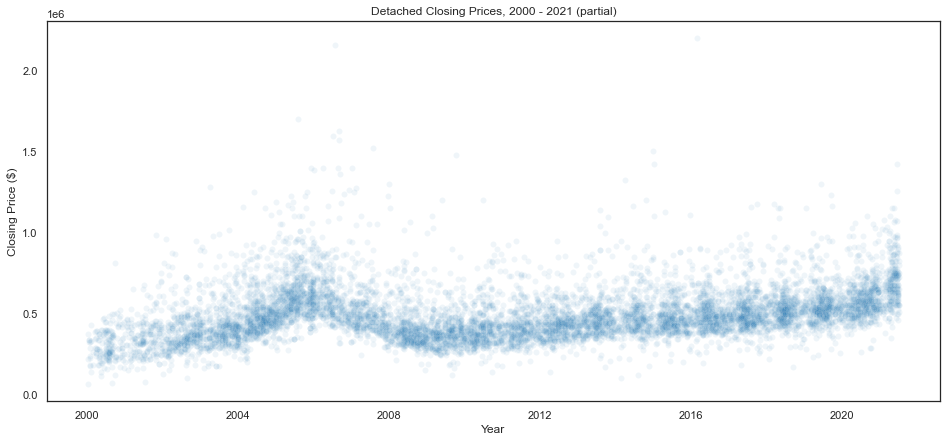

In [40]:
fig3, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df.loc[df['zip_code'] == '20155', :],
                x='close_date',
                y='close_price',
                alpha=0.07,
                ax=ax0)
# plt.axhline(y=575000, ls='--', c='red')
ax0.set_title('Detached Closing Prices, 2000 - 2021 (partial)')
ax0.set_xlabel('Year')
ax0.set_ylabel('Closing Price ($)')

Plotted a boxplot of the closing price for each year contained in the dataframe. This, too, shows the trend contained in the scatterplot above.  This boxplot shows the prevalence of closing price outliers. Every year contains outliers to the top of the boxplots, but only some show outliers on the low side.

The boxplots for 2007 and 2008 exhibit what is likely a significant difference between the housing prices for the two years. The box for 2008 is nearly completely below the box of 2007 and the notches have no overlap.

2021's data only contains sales up until 6/15, but the box indicates that 2021 sales prices are continuing to trend upward, but a rate slightly more aggressive than the previous 10+ years would indicate. 2020 indicated an increased upward trend in closing prices, but 2021 has accelerated that trend.

Text(0, 0.5, 'Closing Price ($M)')

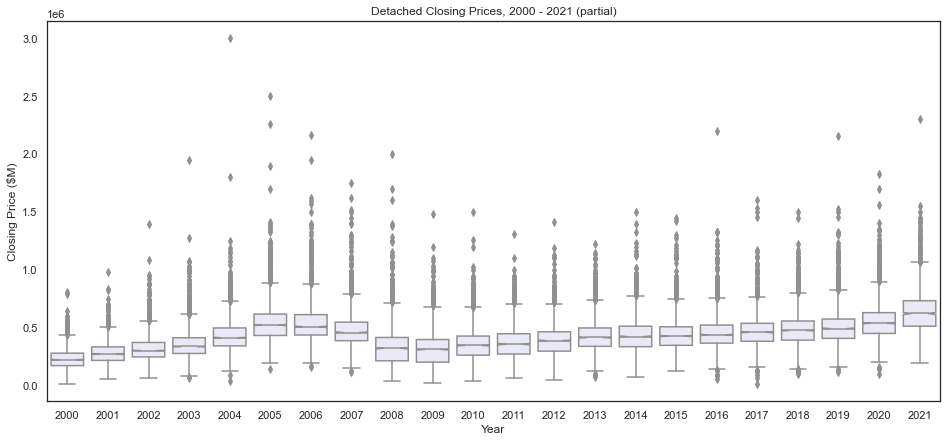

In [41]:
fig4, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_year',
            y='close_price',
            color='lavender',
            notch=True,
            ax=ax0)
ax0.set_title('Detached Closing Prices, 2000 - 2021 (partial)')
ax0.set_xlabel('Year')
ax0.set_ylabel('Closing Price ($M)')

Because the dataframe contains sales data from multiple zip codes, I wanted to see what each zip codes close price vs year looked like. All the zip codes exhibited the same trend, although some zip codes displayed greater variance than others (i.e., 20169 vs 20109 vs. 20181). The differences could be attributed to the number of observations and the fact that a zip code may neighborhoods that generate generally higher close prices than the rest of the zip code.

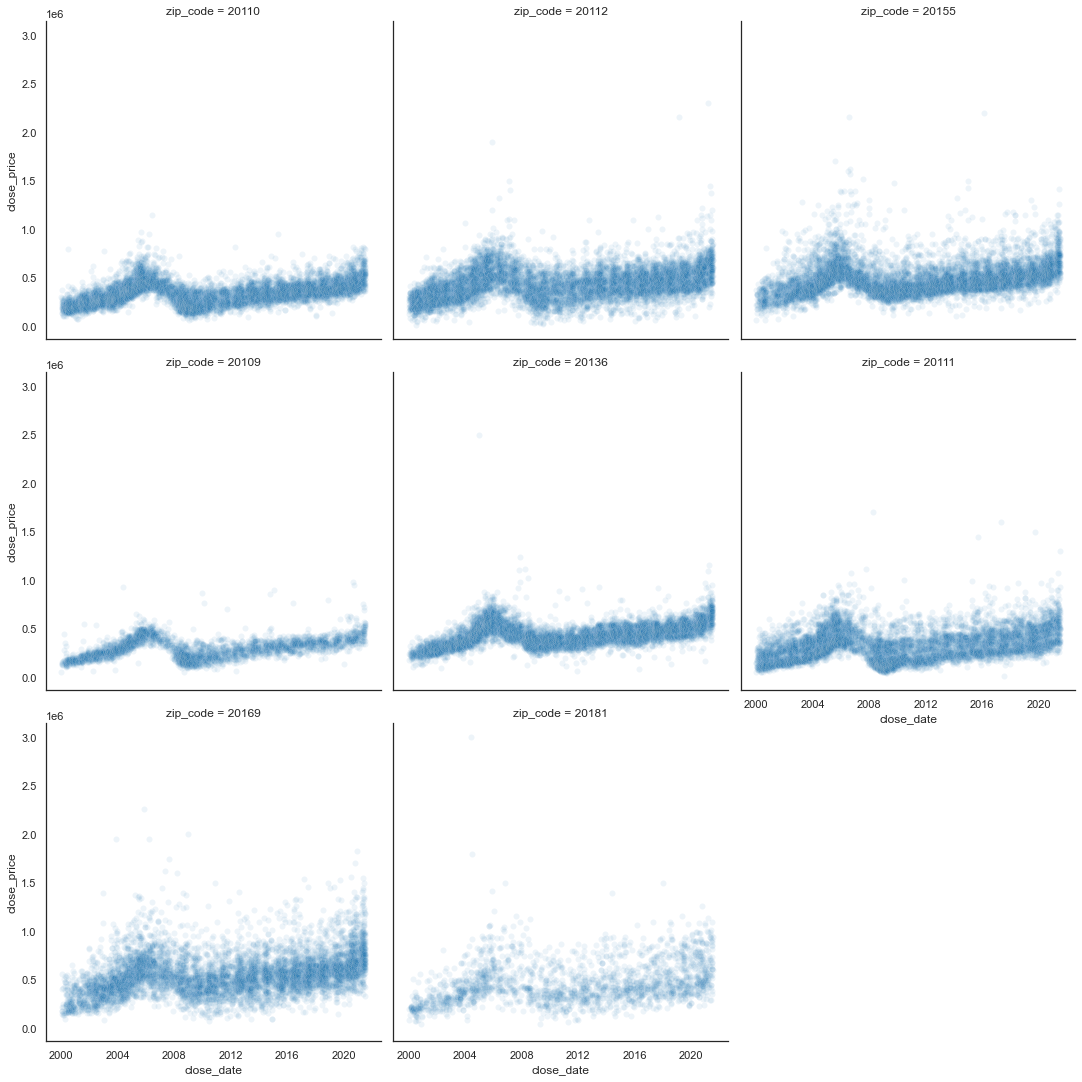

In [42]:
sns.relplot(data=df,
            x='close_date',
            y='close_price',
            kind='scatter',
            col='zip_code',
            col_wrap=3,
            alpha=0.08)

#### DOM (days on market)

In [43]:
df['dom'] = df.dom.str.replace(',', '', regex=False)

In [44]:
df['dom'] = df.dom.astype(int)

Looking at the days on market variable, it is clear that depending on the month a house goes to closure, there is a difference in the number of days it was on the market for sale. The presence of extreme outliers in the days on market variable (i.e., houses that spent more than 500 days for sale) affected the mean and the standard deviation. Looking at the median is more useful in this instance.

For houses that closed in January and February, 50% of houses were on the market for approximately a month.  Meaning 50% of houses put up for sale in November/December waited about 30 days to achieve a ratified contract between buyer and seller.

For houses that closed in May, 50% of houses were on the market for 14 days, or slightly less than half the time of houses that closed in January and February.

The implication is that houses that are put onto the sale market near the end of April and May tend to spend less time waiting for a ratified contract between buyer and seller than other months of the year.

In general, 50% houses that closed from March through July spent fewer than 20 days on the market. In order to take advantage of the historical closing month trend, houses would need to be placed on the market from January to June due to the general gap between contract ratification and settlement.

In [45]:
pd.DataFrame(df.groupby(['close_month'])['dom'].describe())

,count,mean,std,min,25%,50%,75%,max
close_month,,,,,,,,
1,2964.0,60.065452,85.915776,0.0,9.0,32.0,76.0,751.0
2,3084.0,62.591115,95.655519,0.0,8.0,30.0,78.0,861.0
3,4225.0,50.971598,82.695030,0.0,6.0,19.0,65.0,805.0
4,4574.0,44.028640,74.883882,0.0,5.0,15.0,48.0,1007.0
5,5289.0,38.153148,66.913440,0.0,5.0,14.0,40.0,681.0
6,6132.0,38.043216,68.098755,0.0,6.0,15.0,40.0,782.0
7,5226.0,40.841753,66.599703,0.0,7.0,19.0,46.0,837.0
8,5177.0,44.648252,69.357064,0.0,8.0,22.0,55.0,1184.0
9,4235.0,48.514994,81.230510,0.0,8.0,23.0,56.0,2239.0


In [46]:
pd.DataFrame(df.groupby(['close_year'])['dom'].describe())

,count,mean,std,min,25%,50%,75%,max
close_year,,,,,,,,
2000,1675.0,56.082388,95.332383,1.0,6.0,19.0,57.0,861.0
2001,2014.0,80.032771,129.873827,1.0,7.0,22.0,72.0,679.0
2002,2421.0,81.216439,132.238981,0.0,10.0,27.0,77.0,1028.0
2003,2754.0,41.356209,65.025982,0.0,6.0,20.0,49.0,840.0
2004,3405.0,33.879883,67.995040,0.0,5.0,13.0,33.0,683.0
2005,3598.0,34.611729,64.076738,0.0,6.0,15.0,36.0,751.0
2006,2166.0,57.698984,60.830821,0.0,14.0,43.0,84.0,583.0
2007,1775.0,84.206761,87.447298,0.0,20.0,58.0,120.0,796.0
2008,2963.0,68.944313,82.805585,0.0,13.0,39.0,99.5,839.0


The boxplot without the outliers confirms what is seen in the table above. The medians for March - July are all lower than the other months, which indicate these months are better performers from a days on market context.

The green triangles indicate the average days on market for the month. Because of the number and range of the outliers, the means are all well above their respective medians.

<AxesSubplot:xlabel='close_month', ylabel='dom'>

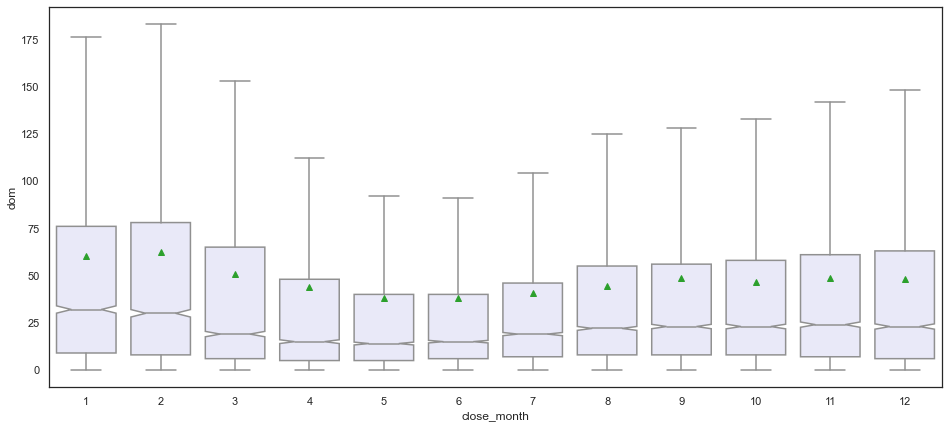

In [47]:
fig5, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_month',
            y='dom',
            color='lavender',
            notch=True,
            showmeans=True,
            showfliers=False,
            ax=ax0)

Text(0, 0.5, 'Frequency')

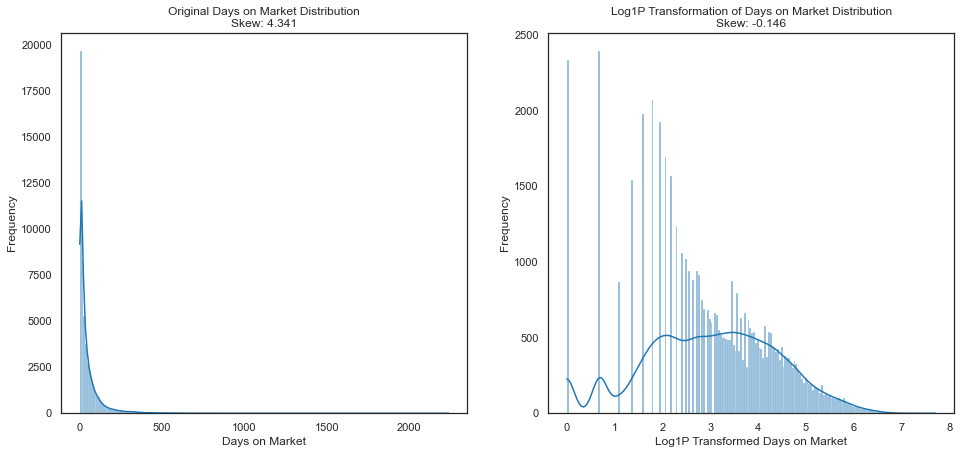

In [48]:
fig8, (ax0, ax1) = plt.subplots(1, 2, figsize=(16, 7))

sns.histplot(data=df,
             x='dom',
             kde=True,
             bins=200,
             ax=ax0)
ax0.set_title(f'Original Days on Market Distribution\n'
              f'Skew: {round(df.dom.skew(), 3)}')
ax0.set_xlabel('Days on Market')
ax0.set_ylabel('Frequency')

sns.histplot(data=df,
             x=np.log1p(df['dom']),
             kde=True,
             bins=200,
             ax=ax1)
ax1.set_title(f'Log1P Transformation of Days on Market Distribution\n'
              f'Skew: {round(np.log1p(df.dom).skew(), 3)}')
ax1.set_xlabel('Log1P Transformed Days on Market')
ax1.set_ylabel('Frequency')

Over time, the number of days on the market has generally remained unchanged. When looking at the scatterplot below, there are some interesting areas, 2000-2003, 2007-2010, and the end of 2020-2021.

From 2000-2003, there are several plumes where the number of days on market showed departures from the main cloud of days between 0 and ~100.

from 2007-2009, the scatterplot cloud increases in height, which indicates that houses in general spent more time on the market.  This characteristic of the scatterplot coincides with Housing Bubble popping and the resulting recession.  Based on the scatterplot cloud, there does not appear to a preceding decrease in number of days on the market prior to the market crash, which would have indicated an increasingly active housing market.

Around 2020, the scatterplot cloud becomes compressed, which indicates that the houses that sold, spent less time on the market than the preceding area.  The decrease in days on market indicates that the housing market became hotter.

<AxesSubplot:xlabel='close_date', ylabel='dom'>

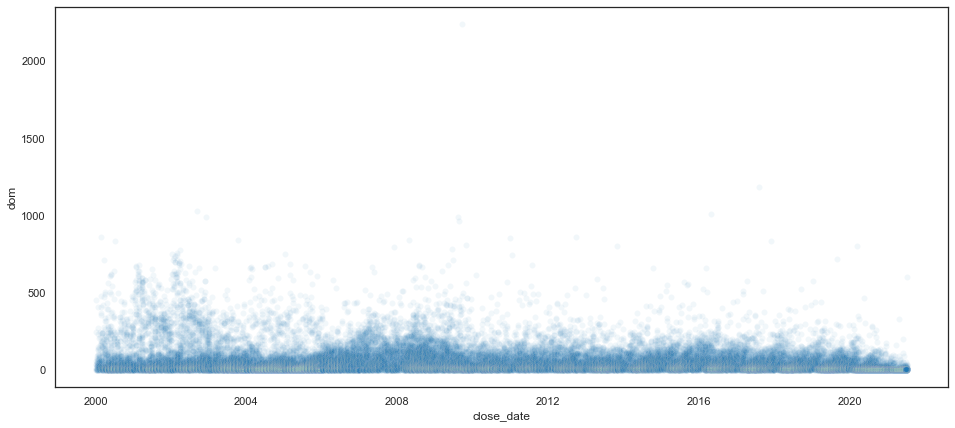

In [49]:
fig6, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df,
                x='close_date',
                y='dom',
                alpha=0.06,
                ax=ax0)

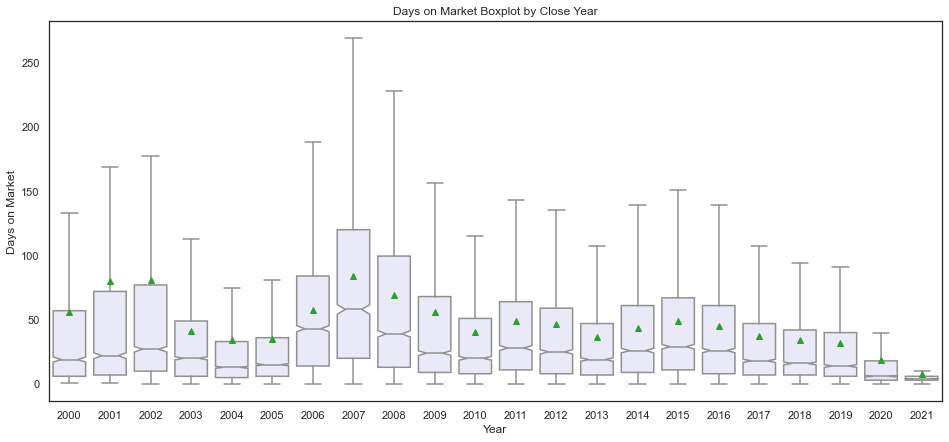

In [52]:
fig20, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.boxplot(data=df,
            x='close_year',
            y='dom',
            color='lavender',
            notch=True,
            showmeans=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('Days on Market Boxplot by Close Year')
ax0.set_xlabel('Year')
ax0.set_ylabel('Days on Market')

fig20.savefig('data/exports/plots/dom_by_year_boxplot.png')

#### HOA

In [ ]:
df.rename(columns={'hoa_yn': 'hoa'}, inplace=True)

In [ ]:
hoa_map = {'Yes': 1,
           'No': 0}

df['hoa'] = df.hoa.replace(hoa_map).astype('int')

Slightly more than half of the houses in the dataset were a part of an HOA at the time of sale.

In [ ]:
hoa_counts = df.hoa.value_counts(dropna=False)
hoa_pcts = df.hoa.value_counts(dropna=False,
                               normalize=True)
pd.concat([hoa_counts, hoa_pcts],
          axis=1,
          keys=['counts', '%'])

Over the timeframe covered in the dataset, the prevalence of homes sold that were part of an HOA increased and then leveled off. From 2000 to 2005, the percent of homes sold that were part of an HOA increased from ~3% to ~56% and the homes that were not part of an HOA were the complement of those HOA percentages. Since 2005, the percent of homes sold that were part of an HOA has more or less remained stable.

In [ ]:
hoa_yr_counts = df.groupby('close_year')['hoa'].value_counts()
hoa_yr_pcts = df.groupby('close_year')['hoa'].value_counts(normalize=True)

hoa_yr_df = pd.concat([hoa_yr_counts, hoa_yr_pcts],
                      axis=1,
                      keys=['counts', '%']).reset_index()
hoa_yr_df

In [ ]:
fig12, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.lineplot(data=hoa_yr_df,
             x='close_year',
             y='%',
             hue='hoa',
             ax=ax0)

ax0.set_title('HOA Percent Over Time')
ax0.set_xlabel('Year')
ax0.set_ylabel('Percent (%)')

A scatterplot was used to look at all sales for the previous 20+ years and associated closing price. Then the scatterplot was configured to show in a contrasting color which houses were part of an HOA at the time of sale.

The plot clearly shows that houses in the dataset that were part of an HOA occupied the upper (higher closing price) part of scatterplot.

The scatterplot also shows that prior to ~2005, most houses that were sold were not part of HOA. Then in ~2005-2006 the incidence of sold houses that were part of an HOA increased in density and remained fairly consistent through the end of the dataset.

In [ ]:
fig9, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df,
                x='close_date',
                y='close_price',
                hue='hoa',
                alpha=0.06,
                ax=ax0)

ax0.set_title('Close Price Over Time Differentiating by HOA Status')
ax0.set_xlabel('Close Year')
ax0.set_ylabel('Close Price ($)')

fig9.savefig('data/exports/plots/close_price_time_hoa_scatterplot.png')

The boxplot below confirms the trend seen in the scatterplot above; the close price for houses in an HOA are higher than the close price for houses that are not in an HOA. The overlap between the two boxes is minimal and the median/notches exhibit no overlap. As a result, HOA is likely a significant variable regarding the closing price of a house from this dataset.

In [ ]:
fig10, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.boxplot(data=df,
            x='hoa',
            y='close_price',
            notch=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('HOA Effect on Close Price')
ax0.set_xlabel('HOA Status')
ax0.set_ylabel('Close Price')

fig10.savefig('data/exports/plots/close_price_hoa_boxplot.png')

I plotted a boxplot to investigate whether HOA status produced a possible affect on the number of days on the market. Based on the plot, days on the market between HOA and non-HOA are essentially the same.

In [ ]:
fig11, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.boxplot(data=df,
            x='hoa',
            y='dom',
            notch=True,
            showfliers=False,
            ax=ax0)

ax0.set_title('HOA Effect on Days on Market')
ax0.set_xlabel('HOA Status')
ax0.set_ylabel('Days on Market')

#### Garage

In [ ]:
garage_map = {'Yes': 1,
              'No': 0}

In [ ]:
df['garage'] = df.garage.replace(garage_map).astype('int')

In [ ]:
df.garage.value_counts(dropna=False)

#### Garage Spaces

Observe the distribution of total garage spaces

In [ ]:
garage_spaces_counts = df.total_garage_spaces.value_counts(dropna=False)
garage_spaces_pcts = df.total_garage_spaces.value_counts(dropna=False,
                                                         normalize=True)

pd.concat([garage_spaces_counts, garage_spaces_pcts],
          axis=1,
          keys=['counts', 'pct'])

In [ ]:
df.loc[df.total_garage_spaces.isnull(), :].head()

Based on a spotcheck of some of the entries that are NaN, the houses with NaN for total garage spaces are NaN because the real estate agent left the field blank instead of entering in a 0.  I will replace all NaN values in the total garage spaces column with 0.

In [ ]:
df.total_garage_spaces.fillna(0,
                              inplace=True)

In [ ]:
df.total_garage_spaces.value_counts(dropna=False)

### Bathrooms - full

In looking at the distribution of full bathrooms, most houses have between 0 and 7.

In [ ]:
bathrooms_full_counts = df.bathrooms_full.value_counts(dropna=False)
bathrooms_full_pcts = df.bathrooms_full.value_counts(dropna=False,
                                                     normalize=True)

pd.concat([bathrooms_full_counts, bathrooms_full_pcts],
          axis=1,
          keys=['counts', '%'])

Several properties have likely erroneous numbers of full bathrooms, for those listings that have more than 7 full bathrooms, the number of full bathrooms will be changed to 7

In [ ]:
df.loc[df.bathrooms_full >= 8, 'bathrooms_full'] = 7

In [ ]:
df.bathrooms_full.value_counts(dropna=False)

### Bathrooms - half

In [ ]:
bathrooms_half_counts = df.bathrooms_half.value_counts(dropna=False)
bathrooms_half_pcts = df.bathrooms_half.value_counts(dropna=False,
                                                     normalize=True)

pd.concat([bathrooms_half_counts, bathrooms_half_pcts],
          axis=1,
          keys=['counts', '%'])

Approximately 1400 listings have null values for half bathrooms. Based on inspection of listings with NaN for the half bathrooms, it appears that agents left the half bathroom field blank instead of putting a 0. I manually updated the NaNs to zero.

In [ ]:
df.loc[df.bathrooms_half.isnull(), :]

In [ ]:
df.bathrooms_half.fillna(0,
                         inplace=True)

In [ ]:
df.bathrooms_half.value_counts(dropna=False)


Approximately 10 listings have 10 or more half bathrooms. Listings with 4 or more half bathrooms will be manually changed to 4 half bathrooms

In [ ]:
df.loc[df.bathrooms_half >= 4, 'bathrooms_half'] = 4

In [ ]:
df.bathrooms_half.value_counts(dropna=False)

#### Fireplaces_total

In [ ]:
df.fireplaces_total.value_counts(dropna=False)

Approximately 1228 listings have null values for total number of fireplaces. Upon inspection, some houses with NaN truly have no fireplaces while some houses do have fireplaces. As a result of the inconsistency in the data, the NaNs will be dropped from the dataframe.

In [ ]:
df.loc[df.fireplaces_total.isnull(), :]

In [ ]:
df = df.loc[df.fireplaces_total.notnull(), :]

In [ ]:
df.fireplaces_total.value_counts(dropna=False)

Perform spotcheck of those houses that have 10 or more fireplaces.

14389 Newbern Loop, Gainseville incorrectly has 108 fireplaces, rather it should be 1
7517 Albermarle Dr, Manassas incorrectly has 10 fireplaces, rather it appears to be 1
5904 Flynnsbrooke Ter, Haymarket incorrectly has 11 fireplaces, rather it should be 2 for a double-sided fireplace
9612 Waterford Dr, Manassas incorrectly has 11 fireplaces, rather it should be 1
15270 Fog Mountain Cir, Haymarket incorrectly has 11 fireplaces, rather it should be 1
13776 Coronado Ct, Manassas incorrectly has 13 fireplaces, rather it should be 1 based on satellite picture
6017 River Forest Dr, Manassas incorrectly has 11 fireplaces, rather it should be 1
10063 Esteppe Dr, Manassas incorrectly has 13 fireplaces, rather it should be 1 based on satellite picture
12928 Larkmeade Ln Manassas incorrectly has 13 fireplaces, rather it will be 1 based on previous trends and lack of pictures
17045 Duck Ln, Haymarket incorrectly has 12 fireplaces, rather it should be 1
12932 Champlain Dr, Manassas incorrectly has 13 fireplaces, rather it should be 1


In [ ]:
print(df.loc[df.fireplaces_total >= 10, ['address', 'city', 'fireplaces_total']].to_string())

In [ ]:
df.loc[df.fireplaces_total >= 10, 'fireplaces_total'] = 1

In [ ]:
df.fireplaces_total.value_counts(dropna=False)

#### Condo_Coop_Assoc_YN

In [ ]:
df.rename(columns={'condo_coop_assoc_yn': 'condo_coop_assoc'},
          inplace=True)

In [ ]:
df.condo_coop_assoc.value_counts(dropna=False)

Three listings have a null value for condo_coop_assoc. Upon inspection of these:

9547 Laurencekirk Pl, Bristow is not a condo_coop so it will be changed to No

12868 Vint Hill Rd, Nokesville is not a condo_coop so it will be changed to No

8163 Snead Loop, Gainesville is not a condo_coop so it will be changed to No

In [ ]:
df.condo_coop_assoc.fillna('No',
                           inplace=True)

In [ ]:
df.condo_coop_assoc.value_counts(dropna=False)


In [ ]:
condo_coop_map = {'Yes': 1,
                  'No': 0}

In [ ]:
df['condo_coop_assoc'] = df['condo_coop_assoc'].replace(condo_coop_map)

In [ ]:
df.condo_coop_assoc.value_counts(dropna=False)

#### Basement

For all houses sold between 1/1/2000 and 7/13/2021, 83% of all houses had a basement. This does not account for finished vs unfinished basements or square footage, just whether or not a house had a basement.

In [ ]:
basement_counts = df.basement.value_counts(dropna=False)
basement_pcts = df.basement.value_counts(dropna=False,
                                         normalize=True)

pd.concat([basement_counts, basement_pcts],
          axis=1,
          keys=['counts', '%'])

In [ ]:
basement_map = {'Yes': 1,
                'No': 0}

In [ ]:
df['basement'] = df.basement.replace(basement_map)

In [ ]:
df.basement.value_counts(dropna=False)

### Levels_stories

65 houses have no reported levels or stories, which does not seem plausible. I performed a spotcheck of those houses that have NaNs. Based on investigation, some of the listings are for plots of land, some are houses with one level and others are multileveled houses. Because of the inconsistency of the listings, they will be dropped from the dataframe.

In [ ]:
df.levels_stories.value_counts(dropna=False)

In [ ]:
df.loc[df.levels_stories.isnull(), ['address', 'city', 'levels_stories']]

In [ ]:
df.loc[df.levels_stories.notnull(), :]

In [ ]:
df = df.loc[df.levels_stories.notnull(), :]

In [ ]:
df.levels_stories.value_counts(dropna=False)

Investigate the listings that have 'other' as the number of levels. Based on a spotcheck, houses with 'other' will be manually changed to 4 levels and stories. This is due to the inconsistency of the data. These houses appear to have multiple stories and levels.

In [ ]:
df.loc[df.levels_stories == 'Other', ['address', 'city', 'levels_stories']]

There is no consistency to what a level or story constitutes, which is why there is a prevalence of 1.5, 2.5, and 3.5 levels.  In order to bring a sense of logic to the levels and stories of a house, a house can have between 1 and 4 levels or stories. Houses with a half level or story get rounded up to the next whole number level or story. Houses with 3.5, other or more levels or stories is capped at 4 levels.

In [ ]:
levels_stories_map = {1: 1,
                      1.5: 2,
                      '1.5': 2,
                      2: 2,
                      '2': 2,
                      2.5: 3,
                      '2.5': 3,
                      3: 3,
                      '3': 3,
                      3.5: 4,
                      '3.5': 4,
                      '3+': 3,
                      4: 4,
                      '4': 4,
                      '5': 4,
                      'Other': 4}

In [ ]:
df['levels_stories'] = df.levels_stories.replace(levels_stories_map)

In [ ]:
df.levels_stories.value_counts(dropna=False)

#### Year

Clearly there are data entry mistakes in the dataset regarding the year a house was built.  Many of the houses that claim to be built prior to 1960 don't appear to be from that time period based on visual inspection.

In [ ]:
df.year_built.value_counts(dropna=False)

14 houses have NaN values for the year in which the house was built. Because of the NaN value, the house will be dropped from the dataset.

In [ ]:
df.year_built.isnull().sum()

In [ ]:
df = df.loc[df.year_built.notnull(), :]

This histogram below shows how the majority of houses were built recently.  The histogram also shows that there are outlier houses whose built year was 0. Houses with a built year of 0 will be dropped.

In [ ]:
df.year_built.plot(kind='hist', bins=100)

In [ ]:
df = df.loc[df.year_built != 0, :]

After dropping houses whose built in year was 0, the resulting histogram shows that the majority of houses were built after 1950. Houses which claim to have been built in 1949 or before will be dropped from the dataset

In [ ]:
fig15, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.histplot(data=df,
             x='year_built',
             bins=100,
             ax=ax0)

ax0.set_title('Distribution of year_built')
ax0.set_xlabel('Year Built')
ax0.set_ylabel('Frequency')

In [ ]:
df = df.loc[df.year_built > 1949, :]

After dropping houses whose listed year built date was prior to 1950, the distribution of houses sold shows that the majority of sold houses were built between 2000 and 2010.

In [ ]:
fig16, ax0 = plt.subplots(1, 1, figsize=(10, 7))

sns.histplot(data=df,
             x='year_built',
             bins=100,
             ax=ax0)

ax0.set_title('Distribution of year_built For Houses Built After 1949')
ax0.set_xlabel('Year Built')
ax0.set_ylabel('Frequency')

#### List price and creation of column to show % change from list to close prices

The dataset contains the list price and the price at which the house ultimately sold for. Because both datapoints are available, it's possible to determine the % above or below the house sold for relative to its listing price.

In [ ]:
df['list_price'] = df.list_price.str.replace('$', '', regex=False)
df['list_price'] = df.list_price.str.replace(',', '')
df['list_price'] = df.list_price.str.split('.', 1, expand=True)[0].astype(int)

The derived close_list_delta column calculates the change from the list price to the close price. When a value is positive, it indicates that the close price was higher than the list price. When a value is negative, the close price was lower than the listing price.

This value can be used as a metric to measure both market and real estate agent performance. If the value for a house in this column is 0, then the real estate agent correctly determined what the market would bear for a house of given characteristics.  In this situation, the seller profits the amount of money that was anticipated at the time of placing the house on the market for sale.

If the value for a house in this column is positive, the agent may have accurately determined what the market would bear for that house, but if the market is in a 'seller's market' then the house price was bid up in a bidding war.  If there was no bidding war, the prospective buyer may have made an offer higher than the list price in an anticipatory move to win the house before any other buyers could make an offer. Here, the seller profits more money than was anticipated at the time of placing the house on the market for sale.

If the value for a house in this column is negative, the agent may have miscalculated what the market would bear for a house of those characteristics. Here the seller profits less money than was anticipated at the time of placing the house on the market for sale.

It must also be noted that depending on the transaction of interest, buying or selling a house, the change in list price to close price may have different meanings. A buyer is interested paying the lowest amount possible whereas the seller prefers to sell at the list price or higher. So, it must be acknowledged that the perspective of the parties involved can change the interpretation of what the numbers represent.

In [ ]:
df['close_list_delta'] = ((df.close_price - df.list_price) / df.list_price)

In [ ]:
df.head(10)

In [ ]:
pd.DataFrame(df.loc[df.close_list_delta >= 0.04, ['mls_#','close_date', 'address', 'city', 'close_price', 'list_price', 'close_list_delta']]).sort_values('close_list_delta', ascending=False)

In [ ]:
close_price_by_yr_df = df.groupby(['close_year'])['close_price'].describe()

In [ ]:
close_price_by_yr_df

In [ ]:
close_price_by_yr_df.to_csv('data/exports/close_price_by_yr_df.csv')

In [ ]:
close_list_delta_yr_df = df.groupby(['close_year'])['close_list_delta'].describe()

In [ ]:
close_list_delta_yr_df

In [ ]:
close_list_delta_yr_df.to_csv('data/exports/close_list_delta_yr_df.csv')

In [ ]:
fig13, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(data=df.loc[df.close_year > 1999, :],
                x='close_date',
                y='close_list_delta',
                alpha=0.07,
                ax=ax0)
ax0.set_title('Close Price to List Price Delta')
ax0.set_xlabel('Close Date')
ax0.set_ylabel('Delta')

plt.axhline(y=0,
            color='red')

fig13.savefig('data/exports/plots/close_list_history_scatter.png')

In [ ]:
fig17, ax0 = plt.subplots(1, 1, figsize=(13, 7))

sns.scatterplot(data=df.loc[(df.close_year > 2018), :],
                x='close_date',
                y='close_list_delta',
                alpha=0.1,
                ax=ax0)
ax0.set_title('Close Price to List Price Delta, since 2019')
ax0.set_xlabel('Close Date')
ax0.set_ylabel('Delta')

sns.scatterplot(data=df.loc[(df.close_year > 2018)&
                            (df.agent_sale_dual == 1), :],
                x='close_date',
                y='close_list_delta',
                color='black',
                ax=ax0)

plt.axhline(y=0,
            color='red')

fig17.savefig('data/exports/plots/close_list_history_2019_scatter.png')

#### Subdivision_Neighborhood

The subdivision_neighborhood feature has 870 different entries. The greatest of which constitutes 4.4% of the entries in the dataset. It is highly likely that there are overlapping classifications where a specific neighborhood for a house is entered, but another house from the same neighborhood is entered with a different entry. As a result, I'll withhold using this as part of my initial modeling efforts. It may be possible to build models for specific neighborhoods, but the column would need to be cleaned to ensure the proper subdivision is entered for a house and not a entry like "Manassas Park", which is a corporate city entity.

In [ ]:
subdivision_counts = df.subdivision_neighborhood.value_counts(dropna=False)
subdivision_pcts = df.subdivision_neighborhood.value_counts(dropna=False,
                                                            normalize=True)

pd.concat([subdivision_counts, subdivision_pcts],
          axis=1,
          keys=['counts', '%'])

In [ ]:
df.isnull().sum()

In [ ]:
df = df.reset_index(drop=True)

In [ ]:
print(df.isnull().sum())
print(df.info())
print(df.head(5))

### Correlation Heatmap of correlation matrix

A correlation matrix and associated heatmap was produced to get a sense of how well correlated, select numeric features were amongst each other and the target feature, close_price.  Based on the results

- close_price & bathrooms_full: 0.59
- close_price & year_built: 0.56
- close_price & total_garage_spaces: 0.50

showed the highest amount of correlation with the close_price.

Upon review of the correlation matrix heatmap, several combinations of the independent variables showed moderate levels of correlation:

- beds & bathrooms_full: 0.51
- year_built & hoa: 0.68,
- year_built & bathrooms_full: 0.50
- year_built & bathrooms_half: 0.45
- year_built & basement: 0.47
- year_built & total_garage_spaces: 0.55

Upon predictive model development, attention will be paid to prevent issues of multicollinearity from happening.

In [ ]:
df_corr = df[['close_price',
              'beds',
              'bathrooms_full',
              'bathrooms_half',
              'basement',
              'fireplaces_total',
              'levels_stories',
              'total_garage_spaces',
              'hoa',
              'year_built',
              'close_month',
              'close_year']].corr()

In [ ]:
df_corr

In [ ]:
mask = np.triu(np.ones_like(df_corr, dtype=bool))

fig6, ax0 = plt.subplots(1, 1, figsize=(16, 7))

cmap = sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(df_corr,
            mask=mask,
            cmap=cmap,
            vmax=1,
            center=0,
            vmin=-1,
            square=True,
            linewidths=0.5,
            cbar_kws={'shrink': 0.5})

### Create X and y datasets

The X and y datasets will comprise the numeric features used above in the correlation matrix investigation plus the zip_code, which is not a numeric feature.

In [ ]:
df.info()

In [ ]:
df.iloc[:, np.r_[6, 2, 7, 8, 9, 12, 13, 14, 15, 21, 26, 28, 29]]

In [ ]:
df = df.iloc[:, np.r_[6, 2, 7, 8, 9, 12, 13, 14, 15, 21, 26, 28, 29]]

In [ ]:
print(df.info())
df.describe()

In [ ]:
df.iloc[:, np.r_[1:13]]

In [ ]:
X = df.iloc[:, np.r_[1:11]]
y = df['close_price']

In [ ]:
X_features = list(X.columns)
X_features

### Split data into training and test sets

In [ ]:
random_seed = 0
train_pct = 0.7
test_pct = 0.3

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_pct,
                                                    train_size=train_pct,
                                                    random_state=random_seed)

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)


https://towardsdatascience.com/time-series-modeling-using-scikit-pandas-and-numpy-682e3b8db8d1

## Unsupervised Learning

## Supervised Learning

#### Linear Regression

## Pipeline Objects


#### Numerical and Categorical Column Lists

In [ ]:
num_columns = make_column_selector(dtype_include=np.number)
numeric_columns = num_columns(X_train)
print(numeric_columns)

In [ ]:
cat_columns = make_column_selector(dtype_include=[object, 'category'])
categorical_columns = cat_columns(X_train)
print(categorical_columns)

### Preprocessing

#### Numerical Transformers

In [ ]:
numeric_column_transformer = make_pipeline(SimpleImputer(strategy='median'),
                                           StandardScaler())

#### Categorical Transformers

In [ ]:
categorical_column_transformer = make_pipeline(SimpleImputer(strategy='most_frequent'),
                                               OneHotEncoder(handle_unknown='ignore'))

#### Create Column Preprocessors

In [ ]:
preprocessor = make_column_transformer((categorical_column_transformer, categorical_columns),
                                       (numeric_column_transformer, numeric_columns),
                                       remainder='passthrough')
preprocessor

### Cross validation object

In [ ]:
rkf_cv = RepeatedKFold(n_splits=5,
                       n_repeats=5,
                       random_state=random_seed)

rkf_gs = RepeatedKFold(n_splits=5,
                       n_repeats=5,
                       random_state=random_seed)

### Specify models

In [ ]:
linreg = LinearRegression()
treereg = DecisionTreeRegressor()
ridgereg = Ridge()
rfreg = RandomForestRegressor()
knnreg = KNeighborsRegressor()

### Linear Regression

#### Linear Regression with no transformations

In [ ]:
linreg_1 = linreg.fit(X_train, y_train)

In [ ]:
linreg_1.score(X_test, y_test)

In [ ]:
print('Linear Regression Model Features and Coefficients - Target and Features Not Transformed')
pd.DataFrame({'Feature': X_train.columns,
              'Coefficients': linreg_1.coef_})

In [ ]:
linreg_1_preds = linreg_1.predict(X_test)

In [ ]:
fig8, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_1_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target and Features Not Transformed')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

#### Linear Regression with scaled features


In [ ]:
linreg_2_pipe = make_pipeline(preprocessor,
                              linreg)

In [ ]:
linreg_2_best_model = linreg_2_pipe.fit(X_train, y_train)

In [ ]:
linreg_2_pipe.score(X_test, y_test)

In [ ]:
linreg_2_preds = linreg_2_pipe.predict(X_test)

In [ ]:
fig9, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_2_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target Not Transformed, Features Transformed (Scaled)')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

Retrieving Features

In [ ]:
features_2 = (linreg_2_pipe['columntransformer'].
              transformers_[0][1].
              named_steps['onehotencoder'].
              get_feature_names(categorical_columns))

In [ ]:
features_2

In [ ]:
features_2 = np.concatenate([features_2, numeric_columns])

In [ ]:
coefs_2 = pd.DataFrame(linreg_2_pipe['linearregression'].coef_,
                       columns=['Coefficients'], index=features_2)

In [ ]:
coefs_2

#### Linear Regression with logged target regressor and scaled features

In [ ]:
linreg_3_pipe = make_pipeline(preprocessor,
                             TransformedTargetRegressor(
                                 regressor=linreg,
                                 func=np.log,
                                 inverse_func=np.exp))

In [ ]:
linreg_3_best_model = linreg_3_pipe.fit(X_train, y_train)

In [ ]:
linreg_3_pipe.score(X_test, y_test)

In [ ]:
linreg_3_preds = linreg_3_pipe.predict(X_test)

In [ ]:
fig10, ax0 = plt.subplots(1, 1, figsize=(16, 7))

sns.scatterplot(x=y_test,
                y=linreg_3_preds,
                alpha=0.1)

ax0.set_title('Linear Regression Model - Target Logged, Features Scaled')
ax0.set_xlabel('Close Prices - Actual')
ax0.set_ylabel('Close Prices - Predicted')

Retreiving Features

In [ ]:
features_3 = (linreg_3_pipe.named_steps['columntransformer'].
              transformers_[0][1].
              named_steps['onehotencoder'].
              get_feature_names(categorical_columns))

In [ ]:
features_3 = np.concatenate([features_3, numeric_columns])

In [ ]:
coefs_3 = pd.DataFrame(linreg_3_pipe['transformedtargetregressor'].regressor_.coef_,
                       columns=['Coefficients'], index=features_3)

In [ ]:
coefs_3


### Decision Tree

#### Decision Tree Regression, no transformations

In [ ]:
ridge_reg_pipe = make_pipeline(non_tree_preprocessor,
                               ridge_reg)

In [ ]:
rf_reg_pipe = make_pipeline(tree_preprocessor,
                            rf_reg)


In [ ]:
knn_reg_pipe = make_pipeline(tree_preprocessor,
                             knn_reg)

### Evaluate Pipelines

In [ ]:
lin_reg_pipe_score = cross_val_score(lin_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
ridge_reg_pipe_score = cross_val_score(ridge_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
rf_reg_pipe_score = cross_val_score(rf_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
knn_reg_pipe_score = cross_val_score(knn_reg_pipe, X_train, y_train, cv=rkf_cv, scoring='neg_mean_squared_error')

In [ ]:
print(f'Linear Regression MSE: {lin_reg_pipe_score.mean()}')
print(f'Ridge Regression MSE: {ridge_reg_pipe_score.mean()}')
print(f'Random Forest Regression MSE: {rf_reg_pipe_score.mean()}')
print(f'KNN Regression MSE: {knn_reg_pipe_score.mean()}')

### Fit pipelines with training data

In [ ]:
lin_reg_pipe.fit(X_train, y_train)

In [ ]:
ridge_reg_pipe.fit(X_train, y_train)

In [ ]:
rf_reg_pipe.fit(X_train, y_train)

In [ ]:
knn_reg_pipe.fit(X_train, y_train)

### Use test data on pipeline to predict

In [ ]:
lin_reg_pipe.predict(X_test)

In [ ]:
ridge_reg_pipe.predict(X_test)

In [ ]:
rf_reg_pipe.predict(X_test)

In [ ]:
knn_reg_pipe.predict(X_test)

### Prediction results